Ajuste Polinomial de Curvas
============================

Esse tutorial visa explicar os conceitos de *overfitting* e regulzarização através de um exemplo de ajuste polinomial de curvas usando o método dos mínimos quadrados. *Overfitting* ocorre quando o modelo decora os dados de entrada, de forma que o modelo se torne incapaz de generalizar para novos dados. Regulzarização é uma técnica para evitar o overfitting.
O tutorial é uma adaptação do exemplo apresentado no capítulo 1 do livro:
"Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning (Information Science and Statistics). Springer-Verlag New York, Inc., Secaucus, NJ, USA."


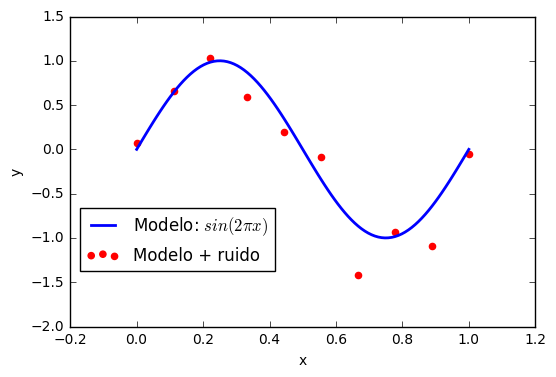

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from ipywidgets import *

#Variância do ruído
var = 0.3

#Conjunto de treino
train_size = 10
x_train = np.linspace(0,1,train_size)
y_train = np.sin(2*np.pi*x_train) + np.random.normal(0,var,train_size) #sinal + ruido

#Conjunto de teste
test_size = 100
x_test= np.linspace(0,1,test_size)
y = np.sin(2*np.pi*x_test)
y_test = y + np.random.normal(0,var,test_size) #sinal + ruido

# Gráfico do sinal sem ruído e do conhunto de treinamento gerado
plt.figure()
plt.plot(x_test,y,linewidth = 2.0,label = r'Modelo: $sin(2 \pi x)$')
plt.scatter(x_train,y_train,color='red',label = "Modelo + ruido")
plt.legend(loc = (0.02, 0.18))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Observações: $$\boldsymbol{X} =(x_1,x_2,...,x_N)^T$$
Alvo:  $$\boldsymbol{T} =(t_1,t_2,...,t_N)^T$$

Dados 
=========

Observações: $$\boldsymbol{X} =(x_1,x_2,...,x_N)^T$$
Alvo:  $$\boldsymbol{T} =(t_1,t_2,...,t_N)^T$$


Modelo
=========

$$y(x,\boldsymbol{W})= w_0 + w_1x +w_2x^2+...+w_mx^m = \sum^M_{j=0}w_jx^j$$

Função de custo 
===============


Função de custo quadrática: $$E(\boldsymbol{W})=\frac{1}{2}\sum_{n=1}^N\{y(x_n,\boldsymbol{W})-t_n\}^2$$

Derivando a função de custo e igualando a zero obtemos o vetor **W*** que minimiza o erro:
$$ \boldsymbol{W}^* = (\boldsymbol{A}^T\boldsymbol{A})^{-1}\boldsymbol{A} ^T\boldsymbol{T}$$

Onde **A** é definido por:

$$\boldsymbol{A} = \begin{bmatrix}
    1 & x_{1} & x_{1}^2 & \dots  & x_{1}^M \\
    1 & x_{2} & x_{2}^2 & \dots  & x_{2}^M \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{N} & x_{N}^2 & \dots  & x_{N}^M
\end{bmatrix}$$

In [2]:
#Implementação da solução dos  mínimos quadrados
def polynomial_fit(X,T,M):
    A = np.power(X.reshape(-1,1),np.arange(0,M+1).reshape(1,-1))
    T = T.reshape(-1,1)
    W = np.dot(np.linalg.pinv(A),T)
    return W.ravel()

Plotando o resultado dos mínimos quadrados para polinômios de graus 0 a 9. **Qual é um bom modelo?**

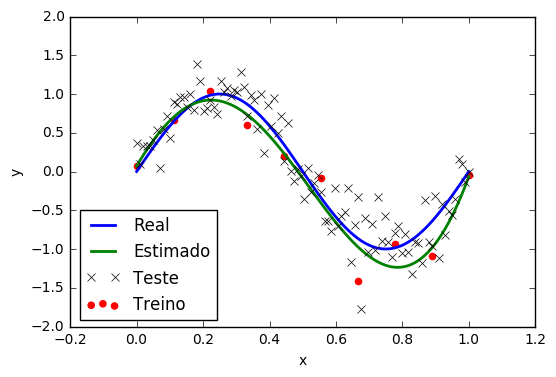

In [3]:
def plotmodel(M):
    coefs = polynomial_fit(x_train, y_train, M)[::-1]
    p = np.poly1d(coefs)
    plt.figure()
    plt.plot(x_test,y,linewidth = 2.0,label = 'Real')
    plt.scatter(x_train,y_train,color='red',label= "Treino")
    plt.xlabel("x")
    plt.ylabel(r'y')
    y_fit = p(x_test) 
    plt.plot(x_test,y_fit,linewidth = 2.0,label ="Estimado")
    plt.plot(x_test,y_test,'x',color='black',label = "Teste")
    plt.legend(loc=(0.02,0.02))

interact(plotmodel,M=(0,9,1))  


Erro RMS ("Root mean squared")
=======================
$$E_{RMS}=\sqrt{2E(\boldsymbol{W^*})/N}$$

Nós queremos encontrar os pesos **W** que minimizam o erro **E(W)**.

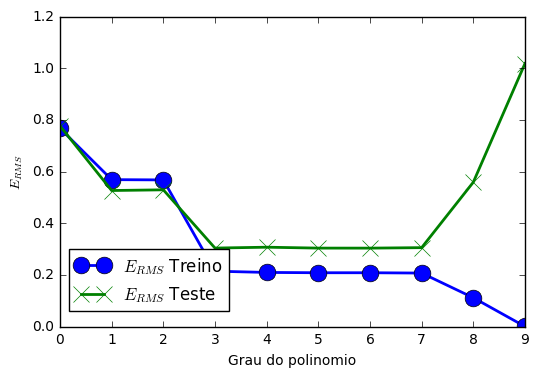

In [4]:
# Cálculo do erro RMS
def rms_error(X,T,W):
    p = np.poly1d(W)
    T_fit = p(X)
    E = np.sqrt(((T - T_fit)**2/T.size).sum())
    return E
   
m = range(10)
train = []
test = []

for M in m:
    W = polynomial_fit(x_train, y_train, M)[::-1]
    error_train = rms_error(x_train,y_train,W)
    error_test = rms_error(x_test,y_test,W)
    train.append(error_train)
    test.append(error_test)


plt.figure()
plt.plot(m,train,linewidth = 2.0,marker = 'o',markersize = 12,label = r'$E_{RMS}$ Treino')
plt.plot(m,test,linewidth = 2.0,marker = 'x',markersize = 12,label = r'$E_{RMS}$ Teste')
plt.legend(loc = (0.02, 0.05))
plt.xlabel("Grau do polinomio")
plt.ylabel(r'$E_{RMS}$')
plt.show()

Função de custo com regularização 
====================================

$$E(\boldsymbol{w})=\frac{1}{2}\sum_{n=1}^N\{y(x_n,\boldsymbol{w})-t_n\}^2 +\frac{\lambda}{2}||\boldsymbol{W}||^2$$

A solução dessa expressão é dada por:

$$\boldsymbol{W}^* = (\boldsymbol{A}^T\boldsymbol{A} + \lambda n\boldsymbol{I})^{-1}\boldsymbol{A} ^T\boldsymbol{T} $$

In [5]:
#Mínimos quadrados com regularização
def polynomial_fit_reg(X,T,M,lamb):
    N = X.shape[0]
    A = np.power(X.reshape(-1,1),np.arange(0,M+1).reshape(1,-1))
    lambda_matrix = lamb*N*np.eye(M+1)
    T = T.reshape(-1,1)
    aux = np.dot(A.T,A) + lambda_matrix
    aux = np.linalg.pinv(aux)
    aux2 = np.dot(A.T,T)
    W = np.dot(aux,aux2)
    return W.ravel()

No demo abaixo, mostramos a influência do $\lambda$ e do $M$ no ajuste polinomial.

W: [  7.35017828   7.09618589 -23.14946924   8.59599928   0.05652992]
Lambda 6.25640794003e-13


<function __main__.plotmodel2>

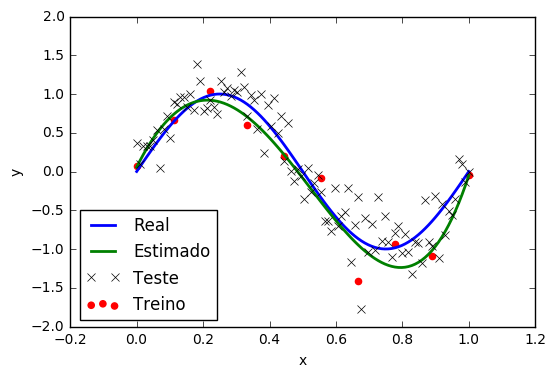

In [6]:
def plotmodel2(M,log_lamb):
    lamb = np.exp(log_lamb)
    coefs = polynomial_fit_reg(x_train, y_train, M,lamb)[::-1]
    print "W:",coefs
    print "Lambda", lamb
    p = np.poly1d(coefs)
    plt.figure()
    plt.plot(x_test,y,linewidth = 2.0,label = 'Real')
    plt.scatter(x_train,y_train,color='red',label= "Treino")
    plt.xlabel("x")
    plt.ylabel(r'y')
    y_fit = p(x_test) 
    plt.plot(x_test,y_fit,linewidth = 2.0,label ="Estimado")
    plt.plot(x_test,y_test,'x',color='black',label = "Teste")
    plt.legend(loc=(0.02,0.02))
interact(plotmodel2,M=(0,9,1),log_lamb = (-40,-15,.1))  

No demo abaixo mostramos a influência do parâmetro $\lambda$ no ajuste de um polinômio de grau 9.

30
30


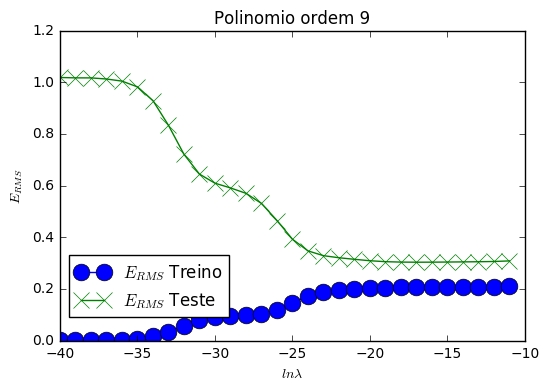

In [7]:
log_lamb = range(-40,-10)

M = 9
train = []
test = []
for l in log_lamb:
    lamb = np.exp(l)
    coeffs = polynomial_fit_reg(x_train, y_train, M,lamb)[::-1]
    error_train = rms_error(x_train,y_train,coeffs)
    error_test = rms_error(x_test,y_test,coeffs)
    train.append(error_train)
    test.append(error_test)

print len(train)
print len(log_lamb)
plt.figure()
plt.plot(log_lamb,train,linewidth = 1.0,marker = 'o',markersize = 12,label = r'$E_{RMS}$ Treino')
plt.plot(log_lamb,test,linewidth = 1.0,marker = 'x',markersize = 12,label = r'$E_{RMS}$ Teste')
plt.legend(loc = (0.02, 0.075))
plt.xlabel(r'$ln\lambda$')
plt.ylabel(r'$E_{RMS}$')
plt.title("Polinomio ordem 9")
plt.show()

Sugestão de atividades:
===============

- Mude o sinal de entrada;
- Mude a intensidade do ruído;
- Use mais dados para treinar o seu modelo;
- ...